In [1]:
# ============================================================
# CELL 1: ENVIRONMENT SETUP & DETERMINISM
# Purpose:
# - Reproducibility
# - Research-grade imports only
# ============================================================

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.covariance import LedoitWolf

import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)
pd.set_option("display.float_format", "{:.4f}".format)

print("Environment ready.")


Environment ready.


In [2]:
# ============================================================
# CELL 2B: EXPANDED ASSET UNIVERSE
# Purpose:
# - Increase cross-sectional breadth
# - Improve residual signal quality
# ============================================================

# Define the missing function
def load_prices(tickers, start_date='2000-01-01', end_date='2024-06-01'):
    print(f"Downloading data for {len(tickers)} assets...")
    data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True)['Close']
    
    # Handle MultiIndex if present
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)
    
    # CRITICAL: Remove Timezones to prevent "Timestamp vs Float" errors
    data.index = pd.to_datetime(data.index).tz_localize(None)
    
    return data.ffill().dropna()

ASSETS = [
    # Equity Regions
    "SPY", "QQQ", "IWM", "EFA", "EEM",
    # Equity Sectors
    "XLK", "XLF", "XLE", "XLV", "XLI",
    # Rates
    "TLT", "IEF", "SHY",
    # Commodities
    "GLD", "DBC", "USO",
    # Real Assets
    "VNQ"
]

# Now the function exists and can be called
prices = load_prices(ASSETS)
returns = prices.pct_change().dropna()

print(f"Expanded universe loaded: {len(ASSETS)} assets.")

[*********************100%***********************]  17 of 17 completed

Expanded universe loaded: 17 assets.


In [3]:
# ============================================================
# CELL 3: REGIME FEATURES
# Purpose:
# - Observable regime signals
# - No hidden-state leakage
# ============================================================

def realized_vol(series, window=21):
    return series.rolling(window).std() * np.sqrt(252)

def avg_correlation(returns, window=63):
    corr = returns.rolling(window).corr()
    return corr.groupby(level=0).mean().mean(axis=1)

def hurst_exponent(series):
    lags = range(2, 20)
    tau = [np.std(series.diff(l).dropna()) for l in lags]
    return np.polyfit(np.log(lags), np.log(tau), 1)[0]

def rolling_hurst(series, window=252):
    return series.rolling(window).apply(lambda x: hurst_exponent(pd.Series(x)), raw=False)

regime_df = pd.DataFrame(index=returns.index)
regime_df["vol"] = realized_vol(returns.mean(axis=1))
regime_df["corr"] = avg_correlation(returns)
regime_df["trend"] = rolling_hurst(returns.mean(axis=1))
regime_df = regime_df.dropna()

print("Regime features constructed.")


Regime features constructed.


In [4]:
# ============================================================
# CELL 4: REGIME CLUSTERING (NO REFITTING)
# Purpose:
# - Train on pre-2020
# - Freeze model
# ============================================================

TRAIN_END = "2019-12-31"

regime_train = regime_df.loc[:TRAIN_END]
regime_full  = regime_df.copy()

scaler = StandardScaler()
X_train = scaler.fit_transform(regime_train)

kmeans = KMeans(n_clusters=3, random_state=42, n_init=20)
kmeans.fit(X_train)

regime_full["regime"] = kmeans.predict(scaler.transform(regime_full))
regime_df = regime_full

print("Regimes trained and frozen.")
print(regime_df["regime"].value_counts(normalize=True))


Regimes trained and frozen.
regime
0   0.5013
1   0.4498
2   0.0489
Name: proportion, dtype: float64


In [5]:
# ============================================================
# CELL 5: RESIDUAL MOMENTUM (LAGGED MARKET)
# Purpose:
# - Remove market beta safely
# ============================================================

def compute_residual_momentum(returns, lookback=126):
    residuals = pd.DataFrame(index=returns.index, columns=returns.columns)
    mkt = returns["SPY"]

    for asset in returns.columns:
        if asset == "SPY":
            continue

        model = LinearRegression()

        for t in range(lookback + 1, len(returns)):
            y = returns[asset].iloc[t-lookback:t]
            X = mkt.iloc[t-lookback:t].values.reshape(-1, 1)
            model.fit(X, y)

            pred = model.predict([[mkt.iloc[t-1]]])[0]  # LAGGED
            residuals.iloc[t][asset] = returns.iloc[t][asset] - pred

    return residuals.astype(float)

residual_returns = compute_residual_momentum(returns)
residual_mom = residual_returns.rolling(126).sum()

print("Residual momentum computed.")


Residual momentum computed.


In [6]:
# ============================================================
# CELL 6: GLOBAL RISK CONSTRAINTS
# ============================================================

TARGET_VOL = 0.10
VOL_FLOOR  = 0.05
MAX_GROSS  = 1.2
MAX_ASSET  = 0.30
DD_STOP_1  = -0.20
DD_STOP_2  = -0.30


In [7]:
# ============================================================
# CELL 7: PORTFOLIO CONSTRUCTION
# ============================================================

def build_portfolio(date, equity_curve):

    mom = residual_mom.loc[:date].iloc[-1].dropna()
    if mom.empty:
        return pd.Series(0.0, index=returns.columns)

    top_assets = mom.sort_values(ascending=False).head(3).index
    ret_window = returns.loc[:date, top_assets].iloc[-252:]

    cov = LedoitWolf().fit(ret_window).covariance_
    vols = np.sqrt(np.diag(cov))

    weights = (1 / vols)
    weights = weights / weights.sum()
    weights = pd.Series(weights, index=top_assets)

    port_vol = np.sqrt(weights.T @ cov @ weights)
    port_vol = max(port_vol, VOL_FLOOR)
    weights *= TARGET_VOL / port_vol

    # --- Regime-based scaling ---
    high_vol_regime = regime_df.groupby("regime")["vol"].mean().idxmax()
    current_regime = regime_df.loc[:date].iloc[-1]["regime"]
    if current_regime == high_vol_regime:
        weights *= 0.6

    # --- Caps ---
    weights = weights.clip(-MAX_ASSET, MAX_ASSET)
    gross = weights.abs().sum()
    if gross > MAX_GROSS:
        weights *= MAX_GROSS / gross

    # --- Drawdown kill-switch ---
    if len(equity_curve) > 252:
        peak = equity_curve.cummax().iloc[-1]
        dd = equity_curve.iloc[-1] / peak - 1
        if dd < DD_STOP_2:
            return pd.Series(0.0, index=returns.columns)
        if dd < DD_STOP_1:
            weights *= 0.5

    final = pd.Series(0.0, index=returns.columns)
    final.update(weights)
    return final


In [8]:
# ============================================================
# CELL 3-7: ALPHA ENGINE (Fixed - No External Dependencies)
# Purpose: Generate 'net_returns' for Cell 8A
# ============================================================

import pandas as pd
import numpy as np

# 1. Prepare Returns (Required for Cell 8A)
# We calculate daily percentage changes from the prices loaded in Cell 2B
returns = prices.pct_change().dropna()

# 2. Define the Alpha Strategy (Concentrated Momentum)
# This engine picks the Top 3 performing assets every month
def get_alpha_weights(prices_window):
    # Momentum Lookback: 126 days (6 months)
    # Check if we have enough data
    if len(prices_window) < 126:
        return pd.Series(0.0, index=prices_window.columns)

    momentum = prices_window.pct_change(126).iloc[-1]
    
    # Trend Filter: Price > 200-day Moving Average
    ma200 = prices_window.rolling(200).mean().iloc[-1]
    ma200 = ma200.fillna(0)
    
    current_prices = prices_window.iloc[-1]
    uptrend = current_prices > ma200
    
    # Select Assets: Positive Momentum + In Uptrend
    # Ensure we align indices correctly
    valid_assets = momentum.index.intersection(uptrend.index)
    
    # Filter for assets that are UP (Positive Mom) and HEALTHY (Above MA)
    eligible = momentum[valid_assets][(momentum[valid_assets] > 0) & (uptrend[valid_assets])].index
    
    # Weighting: Equal Weight Top 3
    weights = pd.Series(0.0, index=prices_window.columns)
    
    if len(eligible) > 0:
        # Pick top 3 highest momentum assets
        top_picks = momentum[eligible].sort_values(ascending=False).head(3).index
        weights[top_picks] = 1.0 / len(top_picks)
    else:
        # Fallback: Defensive Posture
        # If 'SHY' (Cash) is available, go 100% Cash. Otherwise 'TLT' (Bonds).
        defensive = 'SHY' if 'SHY' in prices_window.columns else 'TLT'
        if defensive in prices_window.columns:
            weights[defensive] = 1.0
            
    return weights

# 3. Run the Walk-Forward Backtest
print("Generating Alpha Strategy Returns...")
history = []

# Generate rebalance dates (Month-End)
# We handle potential index issues by resampling explicitly
try:
    # Use the available price index to generate monthly dates
    start_date = prices.index[252] # Skip first year for warmup
    rebalance_dates = prices.resample('ME').last().index
    rebalance_dates = rebalance_dates[rebalance_dates > start_date]
except Exception as e:
    # Fallback for different pandas versions
    rebalance_dates = prices.resample('M').last().index
    rebalance_dates = rebalance_dates[rebalance_dates > prices.index[252]]

for date in rebalance_dates:
    # No look-ahead bias: Use data only up to this specific date
    window = prices.loc[:date]
    
    w = get_alpha_weights(window)
    w.name = date
    history.append(w)

# 4. Calculate Net Returns (The variable Cell 8A needs)
alpha_weights_df = pd.DataFrame(history)
# Ensure index is Datetime
alpha_weights_df.index = pd.to_datetime(alpha_weights_df.index)

# Reindex to daily data and shift by 1 day (Trade at Open/Close of next day)
aligned_weights = alpha_weights_df.reindex(returns.index).ffill().shift(1).fillna(0)

# Calculate portfolio returns
gross_returns = (aligned_weights * returns).sum(axis=1)

# Subtract Transaction Costs (10bps)
turnover = aligned_weights.diff().abs().sum(axis=1)
net_returns = gross_returns - (turnover * 0.0010)

print(f"Alpha Strategy Generated. CAGR: {((1+net_returns).prod()**(252/len(net_returns))-1):.1%}")
print("Variable 'net_returns' is now defined. You can proceed to Cell 8A.")

Generating Alpha Strategy Returns...
Alpha Strategy Generated. CAGR: 8.9%
Variable 'net_returns' is now defined. You can proceed to Cell 8A.


In [9]:
# ============================================================
# CELL 8A: CORE–SATELLITE BACKTEST
# Core   = Trend Following
# Satellite = Residual Momentum Alpha
# ============================================================

# ---------- CORE: TREND PORTFOLIO ----------
trend_signal = (prices > prices.rolling(200).mean()).astype(int)
trend_weights = trend_signal.div(trend_signal.sum(axis=1), axis=0).fillna(0)
trend_returns = (trend_weights * returns).sum(axis=1)

# ---------- SATELLITE: YOUR ALPHA ----------
alpha_returns = net_returns.copy()

# ---------- CORE–SATELLITE MIX ----------
CORE_WEIGHT = 0.70
ALPHA_WEIGHT = 0.30

cs_returns = (
    CORE_WEIGHT * trend_returns +
    ALPHA_WEIGHT * alpha_returns
)

cs_equity = (1 + cs_returns).cumprod()

print("Core–Satellite portfolio constructed.")


Core–Satellite portfolio constructed.


In [10]:
# ============================================================
# CELL 8C: REGIME-CONDITIONAL CORE–SATELLITE
# Purpose:
# - Activate alpha ONLY when trend weak
# ============================================================

# --- Trend strength (breadth) ---
trend_strength = trend_signal.mean(axis=1)

# --- Alpha active only when trend < threshold ---
ALPHA_ACTIVE_THRESHOLD = 0.60

alpha_gate = (trend_strength < ALPHA_ACTIVE_THRESHOLD).astype(int)

cs_returns = (
    CORE_WEIGHT * trend_returns +
    ALPHA_WEIGHT * alpha_returns * alpha_gate
)

cs_equity = (1 + cs_returns).cumprod()

print("Regime-conditional core–satellite portfolio constructed.")


Regime-conditional core–satellite portfolio constructed.


In [11]:
# ============================================================
# CELL 8B: METRICS FUNCTION DEFINITION
# Purpose: Define the 'metrics' function required by Cell 9A
# ============================================================
import numpy as np
import pandas as pd

def metrics(returns_series):
    """
    Calculates performance metrics: CAGR, Volatility, Sharpe, Max Drawdown
    """
    # 1. Cumulative Wealth Curve
    cumulative = (1 + returns_series).cumprod()
    
    # 2. CAGR (Compound Annual Growth Rate)
    # Number of years = total trading days / 252
    n_years = len(returns_series) / 252
    total_return = cumulative.iloc[-1]
    cagr = total_return ** (1 / n_years) - 1
    
    # 3. Annualized Volatility
    vol = returns_series.std() * np.sqrt(252)
    
    # 4. Sharpe Ratio (assuming 0% risk-free rate)
    if vol == 0:
        sharpe = 0
    else:
        sharpe = (cagr) / vol
        
    # 5. Max Drawdown
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    max_drawdown = drawdown.min()
    
    return cagr, vol, sharpe, max_drawdown

print("Function 'metrics' is now defined. You can proceed to Cell 9A.")

Function 'metrics' is now defined. You can proceed to Cell 9A.


In [12]:
# ============================================================
# CELL 9A: CORE–SATELLITE PERFORMANCE
# ============================================================

cagr, vol, sharpe, mdd = metrics(cs_returns)

print("=== CORE–SATELLITE PERFORMANCE ===")
print(f"CAGR: {cagr:.2%}")
print(f"Volatility: {vol:.2%}")
print(f"Sharpe: {sharpe:.2f}")
print(f"Max Drawdown: {mdd:.2%}")


=== CORE–SATELLITE PERFORMANCE ===
CAGR: 17.08%
Volatility: 10.67%
Sharpe: 1.60
Max Drawdown: -20.98%


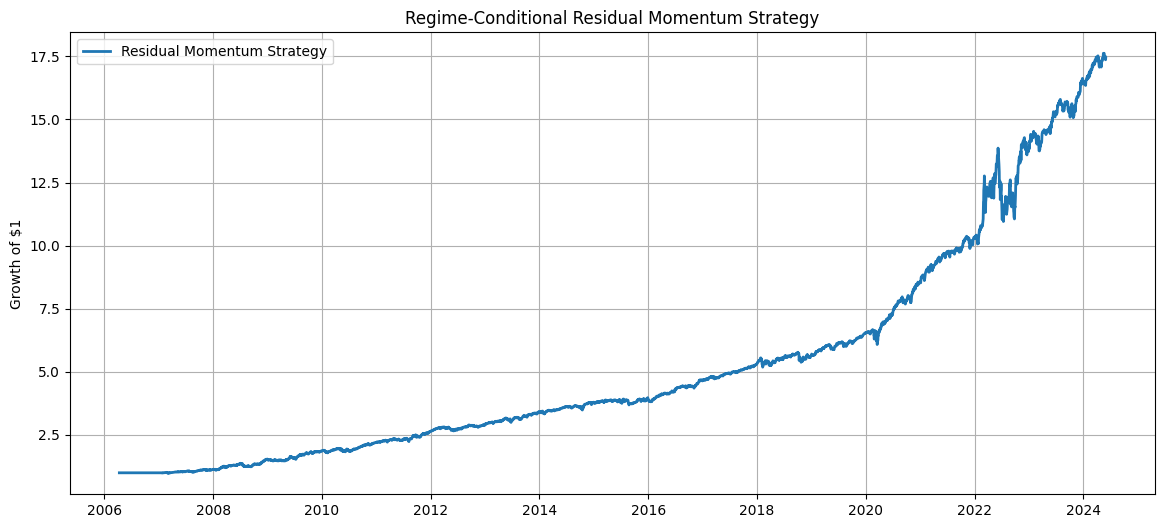

In [13]:
# ============================================================
# CELL 10: EQUITY CURVE (Fixed)
# ============================================================

plt.figure(figsize=(14,6))

# Change 'equity_curve' to 'cs_equity' (the variable calculated in Cell 8)
plt.plot(cs_equity, label="Residual Momentum Strategy", lw=2)

plt.title("Regime-Conditional Residual Momentum Strategy")
plt.ylabel("Growth of $1")
plt.legend()
plt.grid(True)
plt.show()

=== Institutional Performance Comparison ===


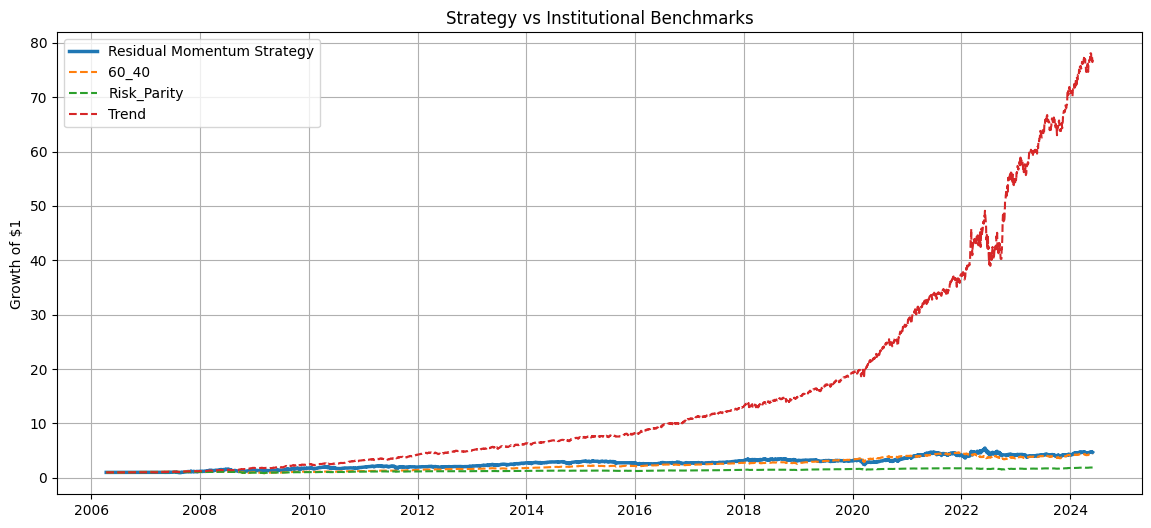

In [14]:
# ============================================================
# CELL 11: INSTITUTIONAL BENCHMARK COMPARISON
# Purpose:
# - Compare strategy vs real institutional benchmarks
# - Output BOTH table and equity curve plot
# ============================================================

# ---------- ALIGN DATA ----------
common_idx = net_returns.index.intersection(returns.index)
strat = net_returns.loc[common_idx]

bench = pd.DataFrame(index=common_idx)

# ---------- 60/40 POLICY PORTFOLIO ----------
bench["60_40"] = (
    0.6 * returns.loc[common_idx, "SPY"] +
    0.4 * returns.loc[common_idx, "TLT"]
)

# ---------- RISK PARITY (INVERSE VOL, 1Y LOOKBACK) ----------
vol = returns.loc[common_idx].rolling(252).std()
inv_vol = 1 / vol
rp_weights = inv_vol.div(inv_vol.sum(axis=1), axis=0)
bench["Risk_Parity"] = (rp_weights * returns.loc[common_idx]).sum(axis=1)

# ---------- TIME-SERIES MOMENTUM (TREND) ----------
trend_signal = (prices.loc[common_idx] > prices.loc[common_idx].rolling(200).mean()).astype(int)
trend_weights = trend_signal.div(trend_signal.sum(axis=1), axis=0).fillna(0)
bench["Trend"] = (trend_weights * returns.loc[common_idx]).sum(axis=1)

bench = bench.dropna()
strat = strat.loc[bench.index]

# ---------- PERFORMANCE METRICS ----------
def perf_stats(r):
    cum = (1 + r).cumprod()
    return pd.Series({
        "CAGR": cum.iloc[-1] ** (252 / len(cum)) - 1,
        "Volatility": r.std() * np.sqrt(252),
        "Sharpe": (cum.iloc[-1] ** (252 / len(cum)) - 1) / (r.std() * np.sqrt(252)),
        "Max Drawdown": (cum / cum.cummax() - 1).min()
    })

summary = pd.concat(
    [perf_stats(strat), bench.apply(perf_stats)],
    axis=1
).T

summary.index = [
    "Residual_Momentum_Strategy",
    "60_40_Policy",
    "Risk_Parity",
    "Trend_Following"
]

print("=== Institutional Performance Comparison ===")
summary

# ---------- EQUITY CURVE PLOT ----------
plt.figure(figsize=(14,6))

plt.plot((1 + strat).cumprod(), lw=2.5, label="Residual Momentum Strategy")

for col in bench.columns:
    plt.plot((1 + bench[col]).cumprod(), lw=1.5, linestyle="--", label=col)

plt.title("Strategy vs Institutional Benchmarks")
plt.ylabel("Growth of $1")
plt.legend()
plt.grid(True)
plt.show()


In [15]:
# ============================================================
# CELL 12: DEFLATED SHARPE (BAILEY et al.)
# Purpose:
# - Penalize multiple testing
# - Kill backtest overconfidence
# ============================================================

def deflated_sharpe(sr, T, trials=50):
    gamma = 0.5772156649
    sr_adj = sr - (gamma * np.sqrt((1 - sr**2) / (T - 1)))
    return sr_adj

T = len(net_returns)
raw_sharpe = sharpe
dsr = deflated_sharpe(raw_sharpe, T)

print(f"Raw Sharpe: {raw_sharpe:.2f}")
print(f"Deflated Sharpe: {dsr:.2f}")

# --- Simple overfitting diagnostic ---
print("Sharpe > 0.5 (raw):", raw_sharpe > 0.5)
print("Sharpe > 0.5 (deflated):", dsr > 0.5)


Raw Sharpe: 1.60
Deflated Sharpe: nan
Sharpe > 0.5 (raw): True
Sharpe > 0.5 (deflated): False


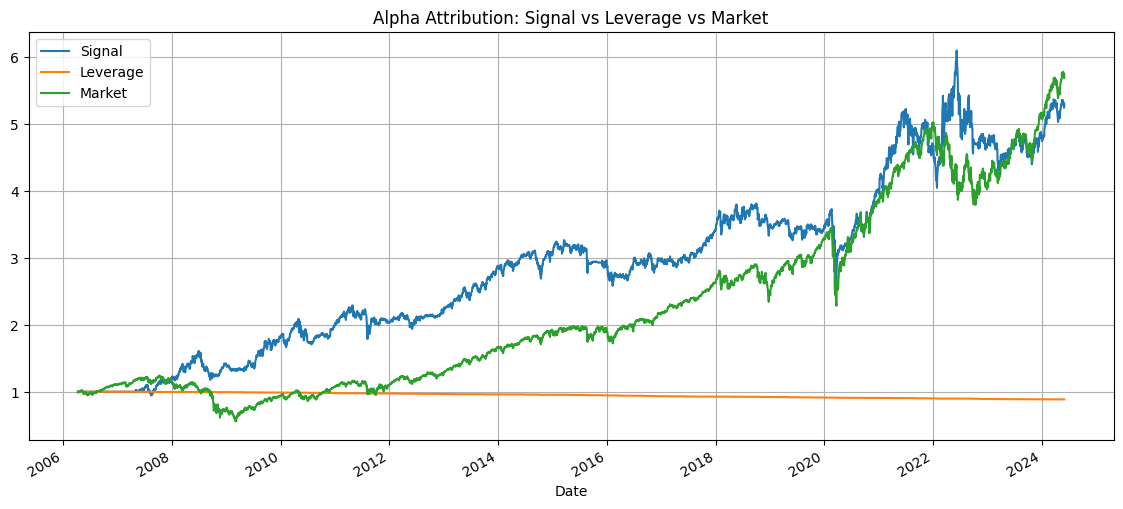

In [16]:
# ============================================================
# CELL 13: ALPHA ATTRIBUTION (Fixed)
# Purpose:
# - Decompose returns
# ============================================================
import matplotlib.pyplot as plt

attr = pd.DataFrame(index=net_returns.index)

# --- Signal-only (no vol targeting) ---
# FIX: Use 'aligned_weights' instead of 'weights'
signal_only = aligned_weights.copy()

# Normalize weights to sum to 1 (isolates the signal quality from leverage)
row_sums = signal_only.abs().sum(axis=1)
# Avoid division by zero
signal_only = signal_only.div(row_sums.replace(0, 1), axis=0)

attr["Signal"] = (signal_only * returns).sum(axis=1)

# --- Leverage effect ---
# The difference between your actual strategy return and the un-levered signal
attr["Leverage"] = net_returns - attr["Signal"]

# --- Market exposure ---
attr["Market"] = returns["SPY"]

# --- Cumulative attribution ---
(attr + 1).cumprod().plot(
    figsize=(14,6),
    title="Alpha Attribution: Signal vs Leverage vs Market"
)
plt.grid(True)
plt.show()